In [24]:
import yaml
from omegaconf import OmegaConf

import torch
from utils import make_model, set_random_seed, save_model, load_model
from trainer import train
from dataset import ShapeDataset, load_data
from dataset_config import DATASET_CONFIG

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F

from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import fcluster

import math

import matplotlib.pyplot as plt
from plotting import plot_phases, plot_results, plot_eval, plot_fourier, plot_phases2, plot_masks, plot_slots, build_color_mask, plot_clusters, plot_clusters2

from loss_metrics import get_ar_metrics, compute_pixelwise_accuracy, compute_iou

import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
import ipywidgets as widgets

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

import matplotlib.gridspec as gridspec

import seaborn as sns

from html2image import Html2Image

In [2]:
sns.set()

# Data Paths

In [3]:
dates = [
    "new_tetronimoes/baseline3_fft/3/lstm_100/",
    "new_tetronimoes/cornn_model/2/300iters/"
]

folder = 'experiments/'
hydra_config_file = '.hydra/config.yaml'
paths = [folder + date for date in dates]

# Function to load a YAML file
def load_yaml_file(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)['params']
    
configs = [load_yaml_file(p + hydra_config_file) for p in paths]

 # Setup
seed = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_random_seed(seed)

# Load models

In [4]:
# Load saved models
def load_model(cp_folder, config, device, data_config):
    data_config = data_config[config['dataset']]
    if 'cell_type' in config.keys():
        cell_type = config['cell_type']
    else:
        cell_type = None
    if 'dt1' in config.keys():
        dt = config['dt1']
    else:
        dt = config['dt']
    # Make model
    net = make_model(
        device,
        config['block_type'],
        config['model_type'],
        config['oscillator_type'],
        config['num_classes'],
        config['N'],
        config['M'],
        dt,
        config['min_iters'],
        config['max_iters'],
        data_config['channels'],
        config['hidden_channels'],
        config['rnn_kernel'],
        config['num_blocks'],
        config['num_slots'],
        config['num_iters'],
        data_config['img_size'],
        config['kernel_init'],
        cell_type=cell_type,
        num_layers=config['num_layers'],
    )

    net.load_state_dict(torch.load(cp_folder + "cp.pt"), strict=False)
    net.eval()
    return net.to(device)

In [5]:
models = [load_model(paths[i], configs[i], device, DATASET_CONFIG) for i in range(len(paths))]

# Forward

In [6]:
def forward_cornn(net, x):
    # ENCODE
    #x = net.encoder(x)
    B, C, H, W = x.shape

    # 1) Precompute omega, alpha from single input x
    omega = net.omega_encoder(x)     # shape (B,1,H,W)
    alpha = net.alpha_encoder(x)     # shape (B,1,H,W)

    # Flatten to (B, H*W)
    omega = omega.view(B, net.c_out, -1)
    alpha = alpha.view(B, net.c_out, -1)

    # 2) Initialize hidden states (hy, hz)
    hy_init = net.hy_encoder(x)  # shape (B,1,H,W)
    hy = hy_init.view(B, net.c_out, -1)      # (B,H*W)
    hz = torch.zeros_like(hy)     # start velocity at 0

    # 3) Run dynamics
    y_seq = []
    for t in range(net.T):
        hy, hz = net.cell(
            x_t=x,  # optional usage
            hy=hy, 
            hz=hz, 
            omega=omega, 
            alpha=alpha
        )
        y_seq.append(hy)  # each is (B,H*W)

    ###
    # Stack timeseries => shape (T, B, H*W)
    y_seq = torch.stack(y_seq, dim=0)  # (T, B, C, H*W)
    y_seq = y_seq.permute(1, 3, 2, 0)  # => (B, H*W, C, T)
    y_seq = y_seq.reshape(B*H*W, net.c_out, net.T)  # => (B*H*W, T)
    # 5) Real FFT => shape (B*H*W, T//2 + 1)
    #    then magnitude => same shape
    fft_vals = torch.fft.rfft(y_seq, dim=2)        # complex, shape (B*H*W, C, T//2+1)
    fft_mag = torch.abs(fft_vals)                  # real, same shape
    # 6) MLP readout => (B*H*W, n_classes)
    logits_flat = net.readout(fft_mag.reshape(fft_mag.size(0), -1))
    # 7) Reshape => (B, H, W, n_classes) -> (B, n_classes, H, W)
    logits = logits_flat.view(B, H, W, net.n_classes)
    logits = logits.permute(0, 3, 1, 2).contiguous()  # (B,n_classes,H,W)

    y_seq = y_seq.view(B, H, W, net.c_out, net.T)
    y_seq = torch.permute(y_seq, (0, 4, 3, 1, 2))

    # reshape fft_mag => (B,H,W, T//2+1) to analyze or plot
    fft_mag = fft_mag.view(B, H, W, net.c_out, -1)
    fft_mag = torch.permute(fft_mag, (0, 4, 3, 1, 2))

    return logits, y_seq, fft_mag

def forward_lstm(net, x):
    #x = net.encoder(x)
    B, C, H, W = x.shape

    hy = net.hy_encoder(x) # B x c_out x N x N
    hz = net.hz_encoder(x)
    hc = net.hc_encoder(x) # Only used for lstmcell

    y_seq = []
    for t in range(net.T):
        hy, hz, hc = net.recurrent_cell(hy, hz, hc)
        y_seq.append(hy)

    y_seq = torch.stack(y_seq, dim=1) # (B, T, c_out, H, W)
    fft_vals = torch.fft.rfft(y_seq, dim=1) # (B, K, c_out, H, W)
    fft_mag = torch.abs(fft_vals) # (B, K, c_out, H, W)
    fft_mag = fft_mag.reshape(B, -1, H, W) # (B, K*c_out, H, W)
    logits = net.readout(torch.transpose(fft_mag, 1, 3)) # (B, W, H, n_classes)
    fft_mag = fft_mag.reshape(B, net.K, net.c_out, H, W) # (B, K*c_out, H, W)
    logits = torch.transpose(logits, 1, 3) # (B, n_classes, H, W)
    return logits, y_seq, fft_mag

def eval_model(net, batch, device, config):
    net.eval()
    x, x_target = batch
    x = x.to(device)
    b, c, h, w = x.size()

    if 'baseline' in config['model_type']:
        logits, y_seq, fft_mag = forward_lstm(net.classifier, x)
    else:
        logits, y_seq, fft_mag = forward_cornn(net.classifier, x)
        
    mask = torch.argmax(logits, dim=1)
    return mask, y_seq, fft_mag

# Set up data

In [7]:
# Load data
data_config1 = DATASET_CONFIG['new_tetronimoes']
data_config2 = DATASET_CONFIG['mnist']
_, testset1 = load_data('new_tetronimoes', data_config1)
_, testset2 = load_data('mnist', data_config2)

testloader1 = DataLoader(testset1, batch_size=16, shuffle=True, drop_last=False)
testloader2 = DataLoader(testset2, batch_size=16, shuffle=True, drop_last=False)
batch1 = next(iter(testloader1))
batch2 = next(iter(testloader2))

testsets = {
    'new_tetronimoes' : batch1,
    'mnist' : batch2,
}

In [8]:
masks = []
states = []
ffts = []
for i, net in enumerate(models):
    config = configs[i]
    dataset = config['dataset']
    batch = testsets[dataset]
    model_type = config['model_type']
    if model_type == 'baseline3_fft' or model_type == 'cornn_model':
        mask, y_seq, fft_mag = eval_model(net, batch, device, config)
        masks.append(mask)
        states.append(y_seq)
        ffts.append(fft_mag)

# Plot masks

In [9]:
def plot_masks(masks, title):
    masks = masks.detach().cpu().numpy()
    fig, axes = plt.subplots(1, 16, figsize=(16, 1))
    for i in range(16):
        axes[i].imshow(masks[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    axes[0].set_title(title)
    plt.show()

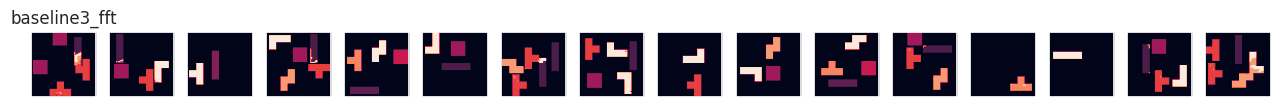

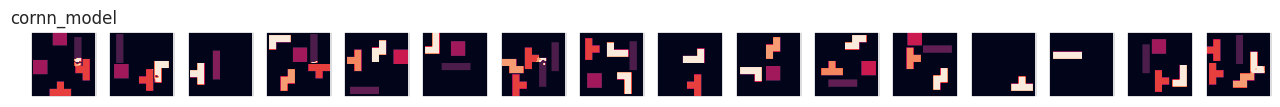

In [10]:
for i, net in enumerate(models):
    plot_masks(masks[i], title=configs[i]['model_type'])

In [13]:
# 2, 4, 5, 7, 8, 9, 10, 11, 12
samples = [2, 4, 5, 7, 8, 9, 10, 11, 12]

# Look at gifs and choose timesteps we want to plot

In [37]:
def plot_hidden_state_video(y_seq, sample_idx=0, interval=200, fpath=None):
    """
    Given y_seq of shape (T,B,H,W), animate the hidden state for the sample
    `sample_idx` across timesteps T.
    
    - `interval` controls the animation speed (milliseconds between frames).
    - returns: HTML object that, when displayed in Jupyter, shows the animation.
    """
    T, B, H, W = y_seq.shape
    assert 0 <= sample_idx < B, f"sample_idx must be in [0..{B-1}]"
    
    # Subsample to 100 frames if sequence is too long
    if T > 100:
        indices = np.linspace(0, T-1, 100, dtype=int)
        y_seq = y_seq[indices]
        T = 100
    
    # We'll animate frames across t=0..T-1
    #  shape => (T,H,W)
    y_seq_np = y_seq[:, sample_idx].cpu().numpy()  # -> (T,H,W)
    
    # We can pick vmin/vmax across the entire timeseries for a stable color scale
    vmin = y_seq_np.min()
    vmax = y_seq_np.max()
    
    fig, ax = plt.subplots()
    im = ax.imshow(y_seq_np[0], cmap='bwr', vmin=vmin, vmax=vmax)
    #ax.set_title(f"Hidden state evolution (sample={sample_idx})")
    ax.set_xticks([])
    ax.set_yticks([])
    #fig.tight_layout()
    plt.colorbar(im, ax=ax)
    
    def animate(t):
        im.set_array(y_seq_np[t])
        ax.set_xlabel(f"t = {t}")
        return [im]
    
    ani = animation.FuncAnimation(
        fig, animate, 
        frames=T, 
        interval=interval, 
        blit=True
    )

    if fpath is not None:
        ani.save(f'{fpath}.gif', writer='pillow', fps=5)

    plt.close(fig)  # so that we don't get a duplicate static plot
    #return HTML(ani.to_jshtml())

def plot_hidden(y, sample, channel, interval=200, fpath=None):
    y = torch.transpose(y, 0, 1).detach()
    return plot_hidden_state_video(y[:,:,channel], sample_idx=sample, interval=200, fpath=fpath)

In [41]:
gif_folder = "gifs"

In [39]:
samples

[2, 4, 5, 7, 8, 9, 10, 11, 12]

In [42]:
for sample in samples:
    fpath = f"{gif_folder}/lstm_sample-{sample}"
    plot_hidden(states[0], sample=sample, channel=0, fpath=fpath)

In [43]:
for sample in samples:
    fpath = f"{gif_folder}/cornn_sample-{sample}"
    plot_hidden(states[1], sample=sample, channel=0, fpath=fpath)